## Girish Amar Budhrani
## CNN(MNIST dataset)

In [1]:
# importing the required models
import gzip
import time
from PIL import Image 
import numpy as np 
from numpy import mean
import random
import pickle
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from numpy import std
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
from sklearn.model_selection import train_test_split
from keras.models import load_model
from keras import regularizers
from numpy import argmax
from keras.layers.core import Dropout

#### Functions to read the label files

In [2]:
# Function to read label data
def read_label(file_name):
    with gzip.open(file_name,'rb') as f:
        value = f.read(4)
        value = int.from_bytes(value,'big')
        nlabels = f. read(4)
        nlabels = int.from_bytes(nlabels,'big')
        print("Total number of labels is:- ",nlabels )
        labels = [f.read(1) for i in range(nlabels)]
        labels = [int.from_bytes(label, 'big') for label in labels]
    return labels
    

#### Function to read images

In [3]:
def read_images(file_name):
    with gzip.open(file_name,'rb') as f:
        value = f.read(4)
        value = int.from_bytes(value ,'big')
        # Total number of images
        nimg = f.read(4)
        nimg = int.from_bytes(nimg,'big')
        print("Total number of images are:- ",nimg)
        
        nrow = f.read(4)
        nrow = int.from_bytes(nrow,'big')
        print("Number of rows:-",nrow)
        
        
        ncol = f.read(4)
        ncol = int.from_bytes(ncol ,'big')
        print("Number of columns",ncol)
        
        images = []
        for i in range(nimg):
            row = []
            for i in range(nrow):
                col = []
                for c in range(ncol):
                    col.append(int.from_bytes(f.read(1), 'big'))
                row.append(col)
            images.append(row)
    return images
        

#### Reading Labels and Images

In [4]:
# Reading labels from dataset
train_labels = read_label("train-labels-idx1-ubyte.gz")
train_labels = np.array(train_labels)
test_labels = read_label("t10k-labels-idx1-ubyte.gz")
test_labels = np.array(test_labels)

Total number of labels is:-  60000
Total number of labels is:-  10000


In [5]:
# Reading images from dataset
train_images = read_images("train-images-idx3-ubyte.gz")
train_images = np.array(train_images)
test_images = read_images("t10k-images-idx3-ubyte.gz")
test_images = np.array(test_images)

Total number of images are:-  60000
Number of rows:- 28
Number of columns 28
Total number of images are:-  10000
Number of rows:- 28
Number of columns 28


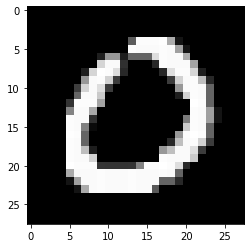

In [6]:
# Ploting random image from traning dataset
image = train_images[random.randint(1,60000)]
fig = plt.figure
plt.imshow(image, cmap = 'gray')
plt.show()

#### Flattening Image data and encoding label data

In [7]:
# Reshaping the traning images from (1,28,28) to (1, 784) and encoding the labels 
trainX = train_images.reshape(train_images.shape[0], 784)
testX = test_images.reshape(test_images.shape[0], 784)
trainy = to_categorical(train_labels)
testy = to_categorical(test_labels)

In [8]:
testy.shape

(10000, 10)

In [9]:
## Variables for convolution layer
convo_trainX = train_images
convo_testX = test_images
convo_trainy = trainy
convo_testy = testy

## Models:

In [10]:
# Defining the model
def def_model(class_model, learning_rate):
    # This model will be fitted when we are tunning the learning rate
    if (class_model == "learning_r"):
        model = Sequential()
        model.add(Dense(128, activation = 'relu', input_shape = (784, )))
        model.add(Dense(500,activation = 'relu'))
        model.add(Dense(500,activation = 'relu'))
        model.add(Dense(10, activation = 'softmax'))
        opt = keras.optimizers.Adam(learning_rate=learning_rate)
        # Compling the Class
        model.compile(optimizer=opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])
        
        
    #  This is a three-layer feedforward
    elif(class_model == "normal"):
        model = Sequential()
        model.add(Dense(128, activation = 'relu', input_shape = (784, )))
        model.add(Dense(500,activation = 'relu'))
        model.add(Dense(500,activation = 'relu'))
        model.add(Dense(10, activation = 'softmax'))
        model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
        
        
    # This model is L2 regularization
    elif(class_model == "l2"):
        model = Sequential()
        model.add(Dense(128,activation='relu', input_shape=(784,), kernel_regularizer=regularizers.l2(0.0001)))
        model.add(Dense(500, activation='relu', kernel_regularizer=regularizers.l2(0.0001)))
        model.add(Dense(500, activation='relu', kernel_regularizer=regularizers.l2(0.0001)))
        model.add(Dense(10, activation='softmax'))
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        
        
    # This model is dropout regularization
    elif(class_model == "dropout"):
        model = Sequential()
        model.add(Dense(128,activation='relu', input_shape=(784,),))
        model.add(Dropout(0.20))
        model.add(Dense(500, activation='relu'))
        model.add(Dense(500, activation='relu'))
        model.add(Dense(10, activation='softmax'))
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        
    # This is a convolutional layers
    elif(class_model == 'convo'):
        model = Sequential()
        model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
        model.add(MaxPooling2D((2, 2)))
        model.add(Flatten())
        model.add(Dropout(0.20))
        model.add(Dropout(0.10))
        model.add(Dense(500,activation = 'relu'))
        model.add(Dense(500,activation = 'relu'))
        model.add(Dense(10, activation = 'softmax'))
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    # Returning the model
    return model

#### Plotting Cross Entropy and classifictaion error

In [11]:
#### This function will plot the cross Entropy, classification error
def plotting_function(histories_save, accuracy):
    print(f"Accuracy: mean = {mean(accuracy) * 100 } std = {std(accuracy) * 100 } n = {len(accuracy)}")
    fig = plt.figure(figsize = (15,10))
    ax1 = fig.add_subplot(2, 1, 1)
    ax2 = fig.add_subplot(2, 1, 2)
    # Plotting cross Entropy
    for i in range(len(histories_save)):
        ax1.set_title('Cross Entropy Loss')
        ax1.plot(histories_save[i]['loss'], color = "blue", label = 'train')
        ax1.plot(histories_save[i]['val_loss'], color = 'orange', label = "test")

        # PLoting classification Error
        # Creating an empty list
        error_loss, val_error = [], []
        for j in histories_save[i]['accuracy']:
            error_loss.append(1 - j)
        for j in histories_save[i]['val_accuracy']:
            val_error.append(1 - j)
        ax2.set_title('Classification Error')
        ax2.plot(error_loss, color = "blue", label = 'train')
        ax2.plot(val_error, color = 'orange', label = "test")

    plt.show()

#### This function is to compare the plots between two models

In [12]:
def plotting_compare(histories_nrml , histories_re, name):    
    fig = plt.figure(figsize = (15,20))
    ax1 = fig.add_subplot(4,1,1)
    ax2 = fig.add_subplot(4,1,2)
    ax3 = fig.add_subplot(4,1,3)
    ax4 = fig.add_subplot(4,1,4)
    for i in range(len(histories_save)):
        # PLotting Cross Entropy loss & val loss
        ax1.set_title("Cross Entropy loss(non regularized model vs "+ name +")")
        ax1.plot(histories_save[i]['loss'], color = "blue", label = 'train')
        ax1.plot(histories_re[i]['loss'], color = "orange", label = 'train')



        ax2.set_title("Cross Entropy val_loss(non regularized model vs "+name+")")
        ax2.plot(histories_save[i]['val_loss'], color = 'blue', label = "test")
        ax2.plot(histories_re[i]['val_loss'], color = 'orange', label = "test")

        # PLoting Error & val error
        error_loss = []
        val_error = []
        for j in histories_save[i]['accuracy']:
            error_loss.append(1 - j)
        for j in histories_save[i]['val_accuracy']:
            val_error.append(1 - j)

        error_loss_re = []
        val_error_re = []
        for j in histories_re[i]['accuracy']:
            error_loss_re.append(1 - j)
        for j in histories_re[i]['val_accuracy']:
            val_error_re.append(1 - j)

        ax3.set_title("Classifiction Error (non regularized model VS "+ name +")")
        ax3.plot(error_loss, color = "blue", label = 'train')
        ax3.plot(error_loss_re, color = "orange", label = 'train')


        ax4.set_title("Classifiction val_error (non regularized model VS "+ name +")")
        ax4.plot(val_error, color = 'blue', label = "test")
        ax4.plot(val_error_re, color = 'orange', label = "test")
    plt.show()

#### K-fold data and storing the history of the model

In [14]:
# This model will kfold the data into the nfold parts and then fit the model
def run_model(dataX , datay, nfolds, class_model, learning_rate):
    accuracy, histories = list(), list()
    # Preparing the cress validation
    kfold = KFold(nfolds, shuffle = True , random_state = 1)
    for train_in , test_in in kfold.split(dataX):
        # time.time() is used to note the time that the system will take for an one itterartion
        start = time.time()
        # Selecting rows for train and test
        # calling the def_model function and and storing it in the model variable
        model = def_model(class_model, learning_rate)
        model.summary()
        # Here train data is to train the model and test data is for the validation purpose
        trainX = dataX[train_in]
        trainy = datay[train_in]
        testX = dataX[test_in]
        testy = datay[test_in]
        # Fitting model
        history = model.fit(trainX , trainy, epochs = 1, batch_size = 128, validation_data = (testX, testy), verbose = 0)
        
        # Calculating the Accuracy of the model
        _, acc = model.evaluate(testX,testy, verbose = 0)
        end = time.time()
        print(f"Time:- {round((end - start)/60,2)} minutes")
        print(" Accuracy :-", round(acc * 100,3))
        accuracy.append(acc)
        histories.append(history)
        # Saving the model in the models folder
    model.save('models/'+str(class_model)+str(learning_rate)+'.h5')
    return accuracy , histories

# 1) Build a three-layer feedforward network

#### Running the model

In [15]:
accuracy, histories = run_model(trainX, trainy, 6, "normal", 0)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 500)               64500     
                                                                 
 dense_2 (Dense)             (None, 500)               250500    
                                                                 
 dense_3 (Dense)             (None, 10)                5010      
                                                                 
Total params: 420,490
Trainable params: 420,490
Non-trainable params: 0
_________________________________________________________________
Time:- 0.03 minutes
 Accuracy :- 92.59
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              

#### Saving the value of the histories variable and the accuracy variable in the "History" and "Accuracy" folder so that we can recolect that value whenever we want with out running the model

In [14]:
for i in range(len(histories)):
    np.save("History/history"+str(i)+".npy",histories[i].history)

with open('Accuracy/accuracy_nrm.pickle', 'wb') as f:
    pickle.dump(accuracy, f)

#### Loading the saved history data and accuracy data

In [15]:
histories_save = []
for i in range(6):
    history=np.load('History/history'+str(i)+'.npy',allow_pickle='TRUE').item()
    histories_save.append(history)

with open('Accuracy/accuracy_nrm.pickle', 'rb') as f:
    accuracy = pickle.load(f)

#### Plotting cross-entropy loss & classification error from saved data

Accuracy: mean = 97.34166661898294 std = 0.08274798906828235 n = 6


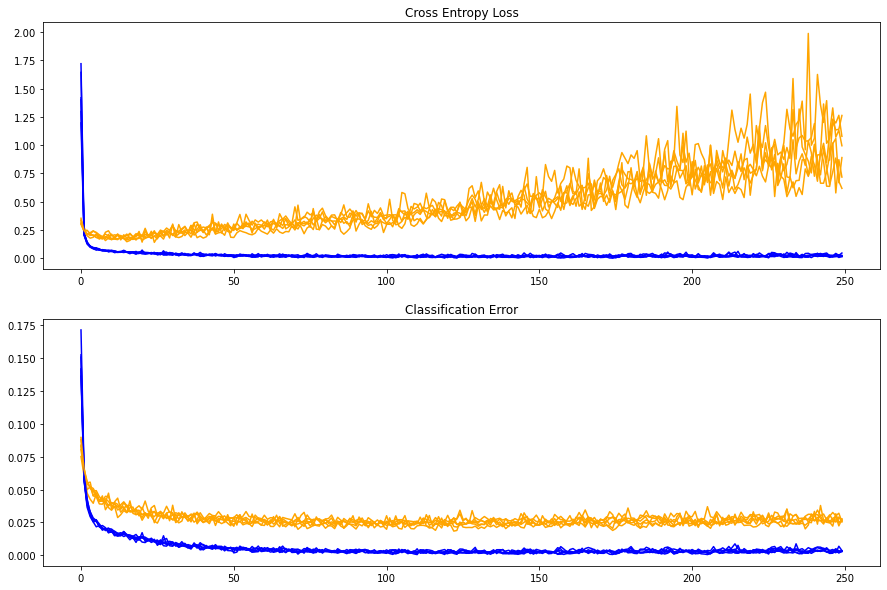

In [16]:
plotting_function(histories_save, accuracy)

## Predicting the output from the trained model

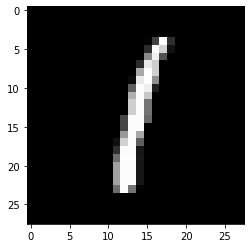

In [17]:
# Loading the saved model
model = load_model("models/normal0.h5")
data_image = testX[random.randint(1,10000)].reshape(1,784)
image = data_image.reshape(28,28)
fig = plt.figure()
plt.imshow(image, cmap = 'gray')
plt.show()

#### Predicting the data from the three-layer feedforward model

In [18]:
predict_v = model.predict(data_image)
digit = argmax(predict_v)
print(f"Number in the above image is {digit}")

Number in the above image is 1


#### Checking the Accuracy of the model from the test data

In [19]:
val = random.randint(1,10000)
wrong = 0
for i in range(10000):
    data_image = testX[i].reshape(1,784)
    image = data_image.reshape(28,28)
    predict_v = model.predict(data_image)
    digit = argmax(predict_v)
    if(digit != test_labels[i]):
        wrong = wrong +1
error = wrong/10000     
print(f"Accuracy for the three-layer feedforward model is {(1-error)*100}")

Accuracy for the three-layer feedforward model is 97.18


# Tunning the Learning rate 

In [20]:
### This is the list of learning rates
learning_list = [0.001, 0.002, 0.003]

#### Running the same model but with the different learning rates, also saving the history and accuracy

In [21]:
for i in learning_list:
    print("\n\n")
    print(f"Learning rate:- {i}")
    accuracy, histories = run_model(trainX, trainy, 6, "learning_r", i)
    for j in range(len(histories)):
        np.save("History/history_tune"+str(i)+str(j)+".npy",histories[j].history)

    with open('Accuracy/accuracy'+str(i)+'.pickle', 'wb') as f:
        pickle.dump(accuracy, f)




Learning rate:- 0.001
Time:- 3.75 minutes
 Accuracy :- 96.97
Time:- 3.86 minutes
 Accuracy :- 97.26
Time:- 3.8 minutes
 Accuracy :- 96.83
Time:- 3.81 minutes
 Accuracy :- 97.28
Time:- 3.81 minutes
 Accuracy :- 97.38
Time:- 3.84 minutes
 Accuracy :- 97.19



Learning rate:- 0.002
Time:- 3.84 minutes
 Accuracy :- 91.99
Time:- 3.86 minutes
 Accuracy :- 94.23
Time:- 3.84 minutes
 Accuracy :- 92.45
Time:- 3.82 minutes
 Accuracy :- 95.58
Time:- 3.83 minutes
 Accuracy :- 95.19
Time:- 3.83 minutes
 Accuracy :- 94.31



Learning rate:- 0.003
Time:- 3.82 minutes
 Accuracy :- 94.11
Time:- 3.81 minutes
 Accuracy :- 95.12
Time:- 3.82 minutes
 Accuracy :- 95.25
Time:- 3.8 minutes
 Accuracy :- 93.58
Time:- 3.79 minutes
 Accuracy :- 90.96
Time:- 3.81 minutes
 Accuracy :- 94.36


#### Loading the data of thr tunnned model from history and accuracy model plus plottting the Tunned model




PLotting for learning rate 0.001 
Accuracy: mean = 97.1516658862432 std = 0.19073768424940246 n = 6


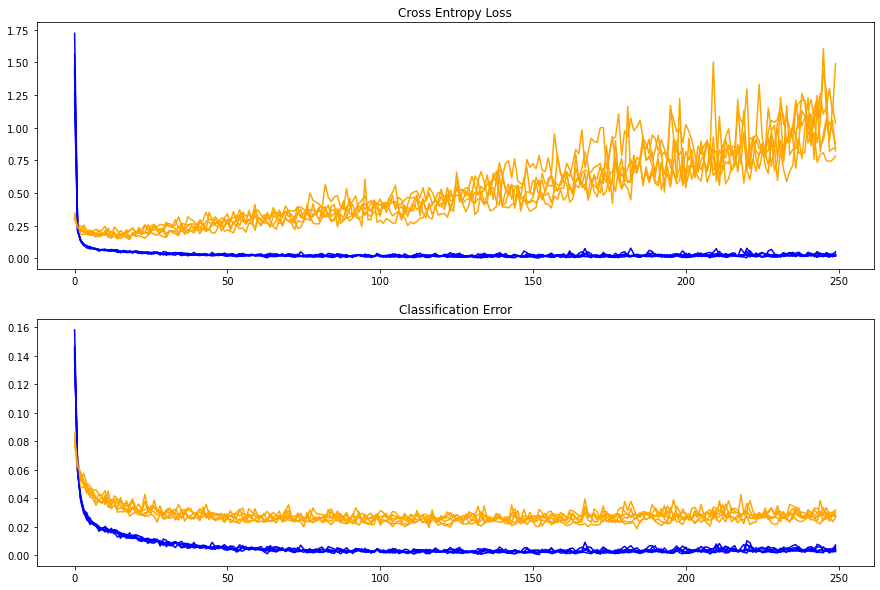




PLotting for learning rate 0.002 
Accuracy: mean = 93.95833313465118 std = 1.322477882742311 n = 6


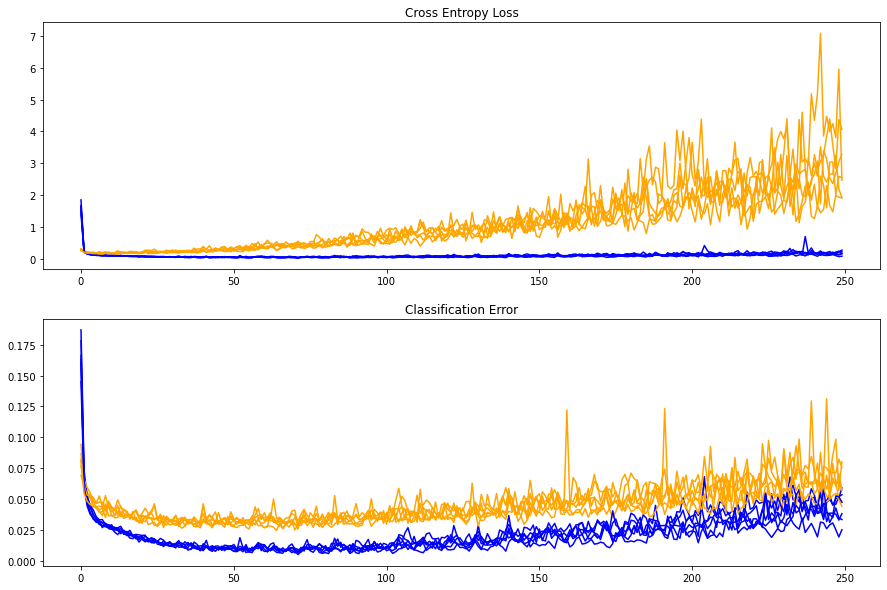




PLotting for learning rate 0.003 
Accuracy: mean = 93.8966671625773 std = 1.4325105607108588 n = 6


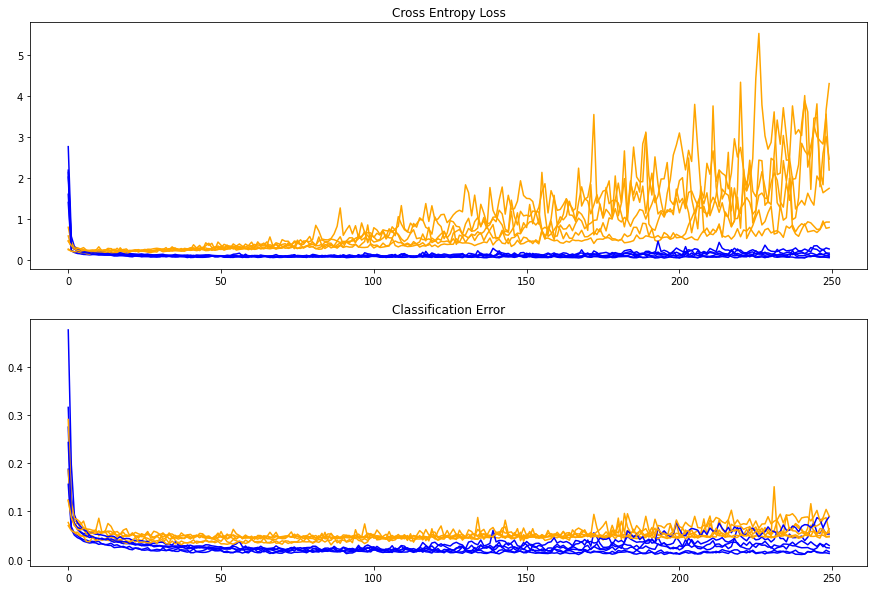

In [22]:
for i in learning_list:
    histories_tune = []
    for j in range(6):
        history=np.load('History/history_tune'+str(i)+str(j)+'.npy',allow_pickle='TRUE').item()
        histories_tune.append(history)

    with open('Accuracy/accuracy'+str(i)+'.pickle', 'rb') as f:
        accuracy_tune = pickle.load(f)
        print("\n\n")
    print(f"PLotting for learning rate {i} ")
    plotting_function(histories_tune, accuracy_tune)

#### Plotting a Random Image from the testing set

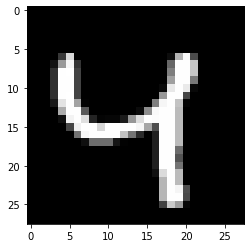

In [66]:
# here model with the learning rate 0.001 is been tested
model = load_model("models/learning_r0.001.h5")
data_image = testX[random.randint(1,10000)].reshape(1,784)
image = data_image.reshape(28,28)
# image = testX[1].reshape(28,28)
fig = plt.figure
plt.imshow(image, cmap = 'gray')
plt.show()

#### Predicting the number that is in the above image

In [67]:
predict_v = model.predict(data_image)
digit = argmax(predict_v)
print(f"Number in the above image is {digit}")

Number in the above image is 4


# 2 A) L2 Regularization

#### Fitting the model


In [38]:
accuracy, histories = run_model(trainX, trainy, 6, "l2",0)

Time:- 4.99 minutes
 Accuracy :- 97.88
Time:- 4.67 minutes
 Accuracy :- 97.5
Time:- 4.73 minutes
 Accuracy :- 97.54
Time:- 4.95 minutes
 Accuracy :- 97.62
Time:- 5.06 minutes
 Accuracy :- 97.44
Time:- 5.13 minutes
 Accuracy :- 97.28


#### Saving the value of the accuracy and the histories variable data into the "Accuracy" and "History" variable

In [39]:
for i in range(len(histories)):
    np.save("History/history_l2"+str(i)+".npy",histories[i].history)

with open('Accuracy/accuracy_l2.pickle', 'wb') as f:
    pickle.dump(accuracy, f)

#### Loading the saved data soo that we can get the required values every time without running the model again and again

In [40]:
histories_l2 = []
for i in range(6):
    history=np.load('History/history_l2'+str(i)+'.npy',allow_pickle='TRUE').item()
    histories_l2.append(history)

with open('Accuracy/accuracy_l2.pickle', 'rb') as f:
    accuracy_l2 = pickle.load(f)

#### Loading the model & plotting the random image from the testing set

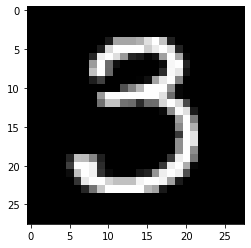

In [41]:
model = load_model("models/l20.h5")
data_image = testX[random.randint(1,10000)].reshape(1,784)
image = data_image.reshape(28,28)
# image = testX[1].reshape(28,28)
fig = plt.figure
plt.imshow(image, cmap = 'gray')
plt.show()

#### Predicting the Number that is in the above image

In [42]:
predict_v = model.predict(data_image)
digit = argmax(predict_v)
print(f"Number in the above image is {digit}")

Number in the above image is 3


### comparing the data

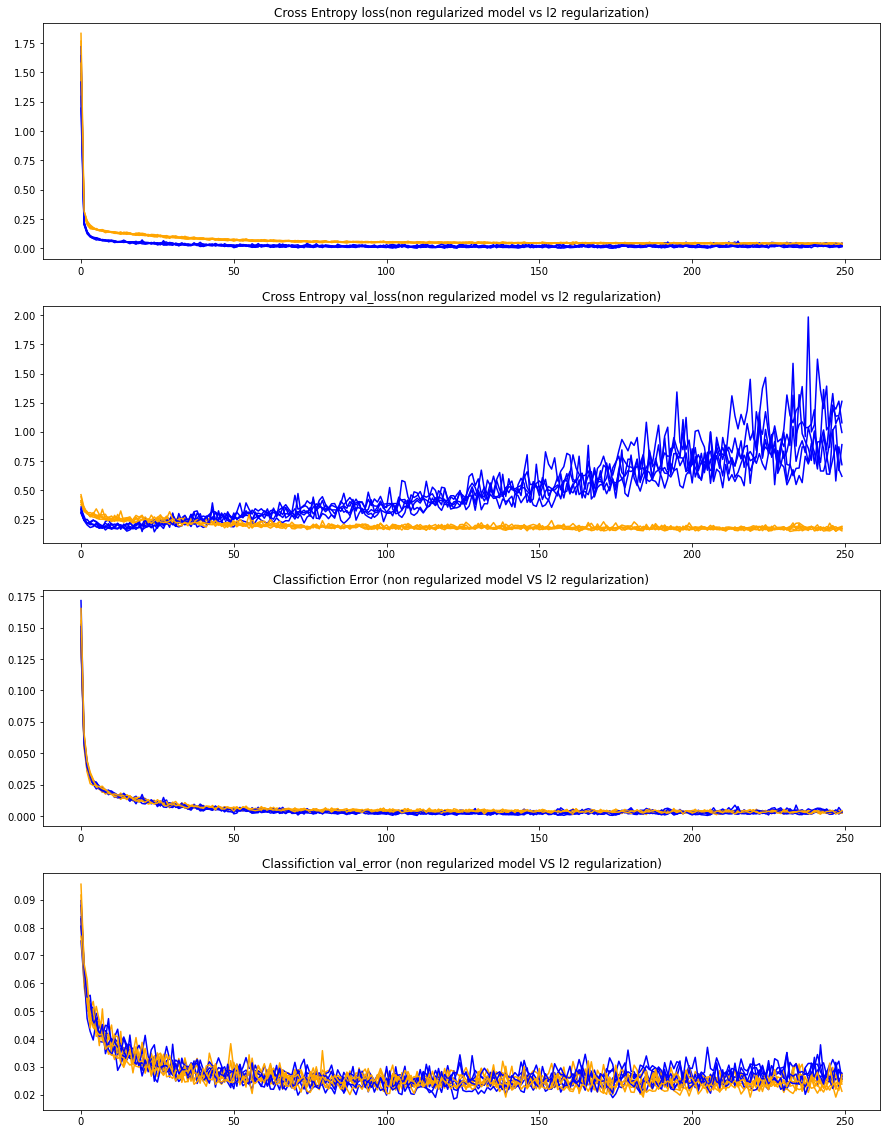

In [43]:
plotting_compare(histories_save , histories_l2 , "l2 regularization")

#### Here we can see that after using the l2 regularization val_loss becomes more constant 

# 2 B) Dropout 

#### Fitting the model

In [44]:
accuracy, histories = run_model(trainX, trainy, 6, "dropout",0)

Time:- 4.52 minutes
 Accuracy :- 97.75
Time:- 4.51 minutes
 Accuracy :- 97.68
Time:- 4.46 minutes
 Accuracy :- 97.95
Time:- 4.48 minutes
 Accuracy :- 97.85
Time:- 4.47 minutes
 Accuracy :- 98.28
Time:- 4.5 minutes
 Accuracy :- 98.02


#### Saving the value of the accuracy and the histories variable data into the "Accuracy" and "History" variable

In [45]:
for i in range(len(histories)):
    np.save("History/history_dropout"+str(i)+".npy",histories[i].history)

with open('Accuracy/accuracy_dropout.pickle', 'wb') as f:
    pickle.dump(accuracy, f)


#### Loading the saved data soo that we can get the required values every time without running the model again and again

In [46]:
histories_drop = []
for i in range(6):
    history=np.load('History/history_dropout'+str(i)+'.npy',allow_pickle='TRUE').item()
    histories_drop.append(history)

with open('Accuracy/accuracy_dropout.pickle', 'rb') as f:
    accuracy_drop = pickle.load(f)

#### Loading the model & plotting the random image from the testing set

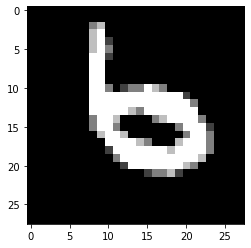

In [60]:
model = load_model("models/dropout0.h5")
data_image = testX[random.randint(1,10000)].reshape(1,784)
image = data_image.reshape(28,28)
# image = testX[1].reshape(28,28)
fig = plt.figure
plt.imshow(image, cmap = 'gray')
plt.show()

#### Predicting the Number that is in the above image

In [61]:
predict_v = model.predict(data_image)
digit = argmax(predict_v)
print(f"Number in the above image is {digit}")

Number in the above image is 6


### comparing the data

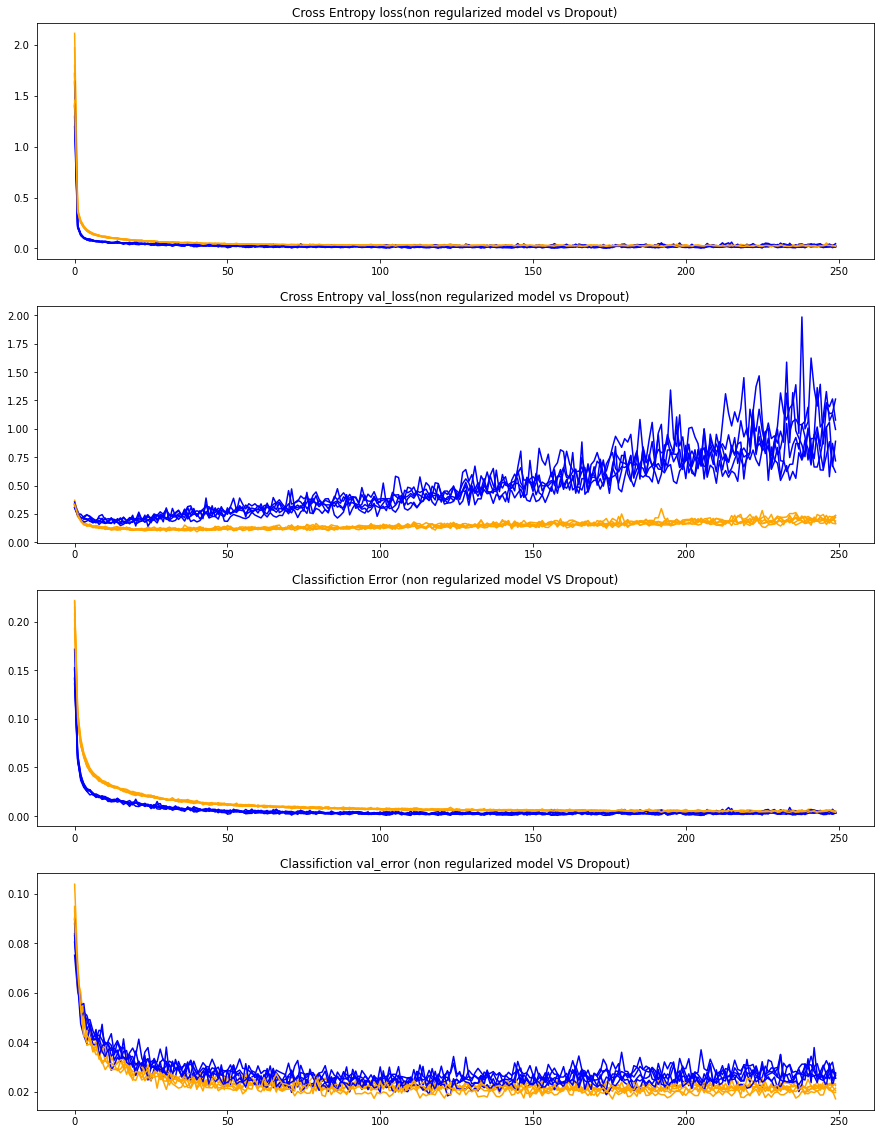

In [49]:
plotting_compare(histories_save , histories_drop, "Dropout")

## 3.) convolutional Layer

### Fitting the model

In [50]:
accuracy, histories = run_model(convo_trainX, convo_trainy, 6, "convo", 0)

Time:- 57.83 minutes
 Accuracy :- 98.02
Time:- 58.4 minutes
 Accuracy :- 98.34
Time:- 57.54 minutes
 Accuracy :- 98.47
Time:- 58.82 minutes
 Accuracy :- 98.64
Time:- 54.22 minutes
 Accuracy :- 98.83
Time:- 58.09 minutes
 Accuracy :- 98.63


#### Saving the value of the accuracy and the histories variable data into the "Accuracy" and "History" variable

In [51]:
for i in range(len(histories)):
    np.save("History/history_convo"+str(i)+".npy",histories[i].history)

with open('Accuracy/accuracy_convo.pickle', 'wb') as f:
    pickle.dump(accuracy, f)


#### Loading the saved data soo that we can get the required values every time without running the model again and again

In [52]:
histories_convo = []
for i in range(6):
    history=np.load('History/history_convo'+str(i)+'.npy',allow_pickle='TRUE').item()
    histories_convo.append(history)

with open('Accuracy/accuracy_convo.pickle', 'rb') as f:
    accuracy_convo = pickle.load(f)

### comparing the data

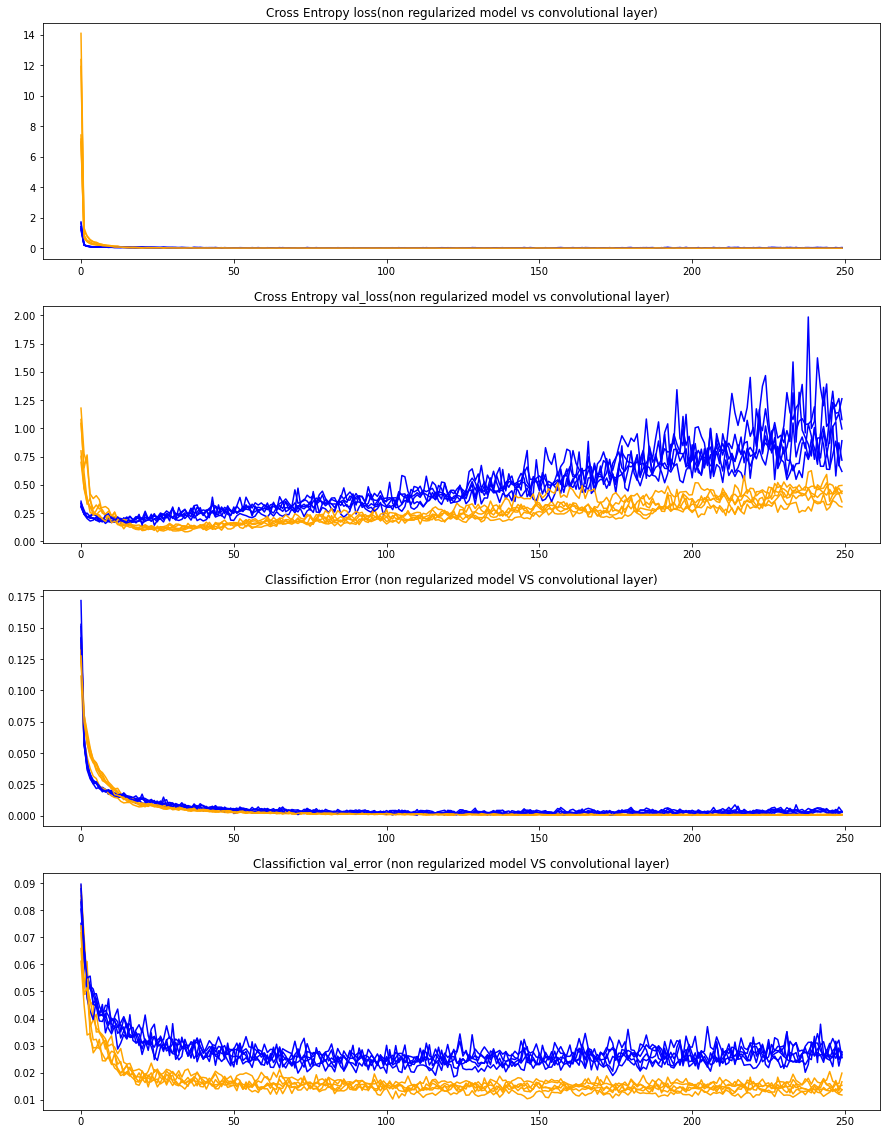

In [53]:
plotting_compare(histories_save , histories_convo, "convolutional layer")

#### Loading the model & plotting the random image from the testing set

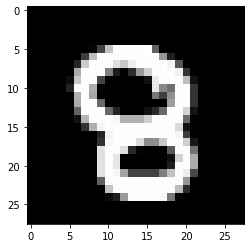

In [56]:
model = load_model("models/convo0.h5")
num = random.randint(1,10000)
data_image = train_images[num].reshape(28, 28, 1)
image = train_images[num].reshape(1,28, 28, 1)
# image = testX[1].reshape(28,28)
fig = plt.figure
plt.imshow(data_image, cmap = 'gray')
# plt.show()

#### Predicting the Number that is in the above image

In [57]:
predict_v = model.predict(image)
digit = argmax(predict_v)
print(f"Number in the above image is {digit}")

Number in the above image is 8
